<a href="https://colab.research.google.com/github/iatra/COSC2673-Assignment2-Group9/blob/main/s4005248_s3980067.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning COSC2673-Assignment2-Group9
Author : Joelle Lee Ming Yin (s3980067) & Isabella Tranquilino (s4005248)

## Approach

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ML A2 Dataset/Image_classification_data.zip'

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

import os

# List first few files/folders in the extraction folder
extracted_path = '/content/data'
for root, dirs, files in os.walk(extracted_path):
    print(f"Directory: {root}")
    for file in files[:5]:  # Show up to 5 files per directory
        print(f"  - {file}")
    break  # Remove this if you want to see all subfolders


Mounted at /content/drive
Directory: /content/data
  - data_labels_mainData.csv
  - data_labels_extraData.csv


In [ ]:
import pandas as pd

df_main = pd.read_csv('/content/data/data_labels_mainData.csv')
df_extra = pd.read_csv('/content/data/data_labels_extraData.csv')

df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


### Class Imbalance Identification

In [ ]:
#--------- Check class imbalance in cellTypeName -------------
class_counts_named = df_main['cellTypeName'].value_counts()
print("Class distribution (by name):")
print(class_counts_named)

# Calculate percentage of each unique cell type
data = {'cellTypeName': ['epithelial'] * 4079 + ['inflammatory'] * 2543 + ['fibroblast'] * 1888 + ['others'] * 1386}
df_temp = pd.DataFrame(data)

class_percentages_named = df_temp['cellTypeName'].value_counts(normalize=True) * 100
print("Class distribution (by percentage):")
print(class_percentages_named.round(2))

Class distribution (by name):
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Class distribution (by percentage):
cellTypeName
epithelial      41.22
inflammatory    25.70
fibroblast      19.08
others          14.01
Name: proportion, dtype: float64


Based on the numbers and percentages, we can identify a class imbalance present in the CellTypeName distribution. We can see that the proportion of each cell is not equal with the epithelial cell being the most frequent.

**Implication:**


1.   The Machine Learning model that we will train might be biased towards the epithelial cell type because it appears the most frequent. The ML model might predict this class more often than the others and it might not identify cell type right.
2.   The model might also struggle to learn characteristics of the minority classes such as 'Fibroblast' due to limited image examples during the training which can lead to low classification scores.




In [ ]:
#--------- Check class imbalance in isCancerous -------------
print("Main Data - isCancerous distribution:")
print(df_main['isCancerous'].value_counts())

# Calculate percentage of isCancerous
main_data = {'isCancerous': [0] * 5817 + [1] * 4079}
df_main_temp = pd.DataFrame(main_data)

main_percentages = df_main_temp['isCancerous'].value_counts(normalize=True) * 100
print("Main Data - isCancerous distribution (by percentage):")
print(main_percentages.round(2))

#--------- Check class imbalance in isCancerous - extra Data -------------
print("Extra Data - isCancerous distribution:")
print(df_extra['isCancerous'].value_counts())

# Calculate percentage of isCancerous - extra Data
class_percentages_extra = df_extra['isCancerous'].value_counts(normalize=True) * 100
print("\nExtra Data - isCancerous distribution (by percentage):")
print(class_percentages_extra.round(2))

Main Data - isCancerous distribution:
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Main Data - isCancerous distribution (by percentage):
isCancerous
0    58.78
1    41.22
Name: proportion, dtype: float64
Extra Data - isCancerous distribution:
isCancerous
0    7394
1    2990
Name: count, dtype: int64

Extra Data - isCancerous distribution (by percentage):
isCancerous
0    71.21
1    28.79
Name: proportion, dtype: float64


Not a drastic change in class imbalance for the main data but for the extra data shows a more significant class imbalance, the non-cancerous class has a larger representation than the cancerous class.

In [ ]:
#--------- Check class imbalance in cellType -------------
class_counts = df_main['cellType'].value_counts().sort_index()
print("Class distribution (by numeric label):")
print(class_counts)

# Calculate percentage of cellType
data_numeric = {'cellType': [0] * 1888 + [1] * 2543 + [2] * 4079 + [3] * 1386}
df_numeric = pd.DataFrame(data_numeric)

class_percentages_numeric = df_numeric['cellType'].value_counts(normalize=True) * 100
print("Class distribution (by percentage):")
print(class_percentages_numeric.round(2).sort_index())

Class distribution (by numeric label):
cellType
0    1888
1    2543
2    4079
3    1386
Name: count, dtype: int64
Class distribution (by percentage):
cellType
0    19.08
1    25.70
2    41.22
3    14.01
Name: proportion, dtype: float64


*There*'s a noticeable class imbalance in the cellType distribution. Class 2 is almost 3 times larger than the Class 3.

#TODO please justify that the class imbalance graphs can be seen in the EDA plots

### Exploratory Data Analysis (EDA)
Some cells of code in this section have been retrieved from the Week 6 Lab and have been adapted to fit this task.

In [ ]:
#--------- Initial exploration into dataframe -------------
df_main.info()
df_main.describe()

#checking for missing vals
df_main.isnull().sum() #no missing labels in any cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


,0
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


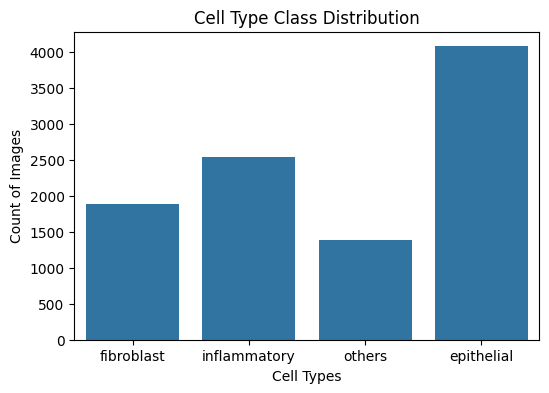

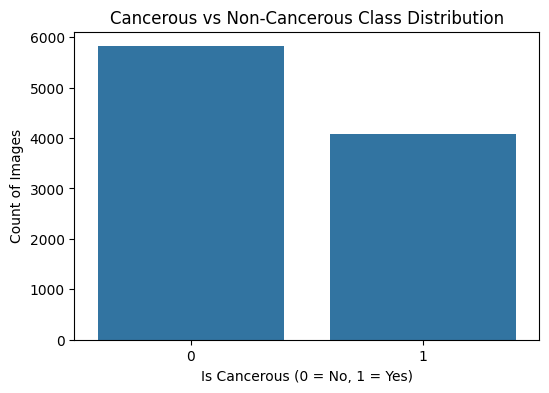

In [ ]:
#-------- Target variables class distributions ----------
df_main['cellTypeName'].value_counts()
df_main['isCancerous'].value_counts()

#plotting distributions
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df_main, x='cellTypeName')
plt.xlabel('Cell Types')
plt.ylabel('Count of Images')
plt.title('Cell Type Class Distribution')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=df_main, x='isCancerous')
plt.xlabel('Is Cancerous (0 = No, 1 = Yes)')
plt.ylabel('Count of Images')
plt.title('Cancerous vs Non-Cancerous Class Distribution')
plt.show()

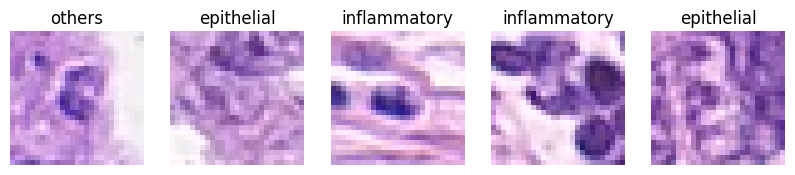

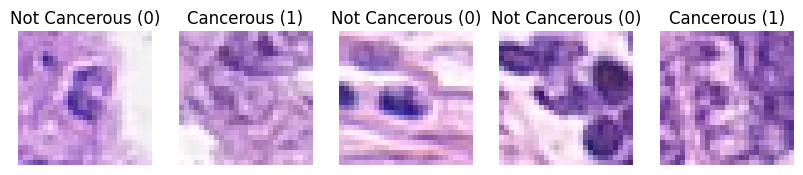

In [ ]:
# ------------- Displaying sample images --------------
import os
from PIL import Image

image_dir = '/content/data/patch_images/'

#grabbing 5 sample images
sample_images = df_main.sample(5)

#displaying sample images
f, axarr = plt.subplots(1, 5, figsize=(10, 5))
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName']) #accessing images from patch_images folder/dir
    img = Image.open(img_path)
    axarr[i].imshow(img)
    axarr[i].axis('off')
    axarr[i].set_title(row['cellTypeName'])  #display cell type names
plt.show()

f, axarr = plt.subplots(1, 5, figsize=(10, 5))
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName']) #accessing images from patch_images folder/dir
    img = Image.open(img_path)
    axarr[i].imshow(img)
    axarr[i].axis('off')
    cancer_identification = "Cancerous (1)" if row['isCancerous'] == 1 else "Not Cancerous (0)" #renaming label 1 or 0 to Cancerous or Not Cancerous
    axarr[i].set_title(cancer_identification)  #display isCancerous or Not
plt.show()


In [ ]:
#----------- Checking image sizes --------------
image_sizes = []

#checking through each image
for img_name in df_main['ImageName']:
    img_path = os.path.join(image_dir, img_name)
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  #size of each image to list
    except:
        continue

print("Image sizes:")
for size in sorted(set(image_sizes)):
    print(size)

Image sizes:
(27, 27)


### Pre-processing of Data

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Add image path to DataFrame by creating a column to benefit adding images later
df_main['ImagePath'] = df_main['ImageName'].apply(lambda x: os.path.join(image_dir, x))

# Convert labels into one-hot encoded formats
y_isCancerous = to_categorical(df_main['isCancerous'].values, num_classes=2)
# Converted cell type labels to one-hot encoded formats 0,1,2,3
y_cellType = to_categorical(df_main['cellType'].values, num_classes=4)

##### Split into training, validation and test set

In [ ]:


# First Split - splitting into 80% for initial training X_train, and 20% test
# y_isCancerous into y1_train, y1_val, and y1_test @Isabella
# y_cellType into y2_train, y2_val, and y2_test @Joelle
# Split is based on isCancerous column to ensure the proportion of cancerous and non-cancerous samples is roughly the same in test and train sets. (Beneficial for potential class imbalance)
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    df_main['ImagePath'].values, y_isCancerous, y_cellType,
    test_size=0.2, stratify=df_main['isCancerous'], random_state=42
)

# Second Split - splitting the 80% further to 60% for training and the validation set to 20%
# Stratifying the split based on isCancerous labels in the training set to convert the one-hot encoded to its original 0 or 1 label. To ensure the validation set also has a good portion of the isCancerous classes.
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(
    X_train, y1_train, y2_train,
    test_size=0.25, stratify=np.argmax(y1_train, axis=1), random_state=42
)

##### Image loader with normalization

In [ ]:
def load_images(image_paths, target_size=(27, 27)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0  # normalize to [0, 1]
        images.append(img)
    return np.array(images)

#### Print train, validation and test shapes

In [ ]:
# Load image arrays
x_train = load_images(X_train) # 72 % of the original data
x_val = load_images(X_val) # 8% of the original data
x_test = load_images(X_test) # 20% of the original data

# Confirm shapes
print("x_train shape:", x_train.shape)
print("y1_train shape (isCancerous):", y1_train.shape)
print("y2_train shape (cellType):", y2_train.shape)

x_train shape: (5937, 27, 27, 3)
y1_train shape (isCancerous): (5937, 2)
y2_train shape (cellType): (5937, 4)


7124 samples in the training set
27x27 height and width of each image
3 RGB colours because the colour isnt grayscaled. The shapes are consistent after normalising to prepare for the classification tasks.

The following are ready for model training:

*   isCancerous prediction - y1_train
*   cellType prediction - y2_train
*   validation models - x_val, y1_val, y2_val
*   final evaluation - x_tests, y1_test, y2_test  


### Task 1: Classifying Cancerous Cell or Not
**Author: Isabella**

#### Model Building (Baseline)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, InputLayer
from tensorflow.keras.utils import to_categorical
from keras import metrics
from tensorflow.keras.optimizers import Adam

In [ ]:
#---------- CNN Y1 (isCancerous) Baseline model architecture ------------
y1_cnn_baseline = Sequential()
y1_cnn_baseline.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
y1_cnn_baseline.add(Activation('relu'))
y1_cnn_baseline.add(MaxPooling2D(pool_size =(2,2)))

y1_cnn_baseline.add(Conv2D(64, (3, 3)))
y1_cnn_baseline.add(Activation('relu'))
y1_cnn_baseline.add(MaxPooling2D(pool_size =(2,2)))

y1_cnn_baseline.add(Flatten())
y1_cnn_baseline.add(Dense(64))
y1_cnn_baseline.add(Activation('relu'))
y1_cnn_baseline.add(Dense(2)) #number of classes for y1
y1_cnn_baseline.add(Activation('softmax'))

optimizer = Adam(learning_rate=0.001)
y1_cnn_baseline.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy',
                              metrics.Precision(name='precision'),
                              metrics.Recall(name='recall'),
                              metrics.AUC(name='auc')]
                     )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fitting y1 onto the baseline model
history_baseline_y1 = y1_cnn_baseline.fit(x_train, y1_train,
                 epochs=100,
                 batch_size=32,
                 validation_data=(x_val, y1_val),
                  verbose=0)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plotting learning curve of baseline model to check for overfitting
def plot_learning_curves(history, metrics_list):
    n_metrics = len(metrics_list)
    plt.figure(figsize=(5 * (n_metrics + 1), 5))

    # Loss learning curve
    plt.subplot(1, n_metrics + 1, 1)
    plt.plot(history.history['loss'], 'r--')
    plt.plot(history.history['val_loss'], 'b--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend(['train', 'val'], loc='upper left')

    # Metrics learning curve
    for i, metric in enumerate(metrics_list, start=2):
        plt.subplot(1, n_metrics + 1, i)
        plt.plot(history.history[metric], 'r--')
        plt.plot(history.history['val_' + metric], 'b--')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.title(f"Training and Validation {metric}")
        plt.legend(['train', 'val'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_learning_curves(history_baseline_y1, ['accuracy', 'precision', 'recall', 'auc'])

**Baseline Model Generalisation**

From the loss, accuracy, recall, and ROC-AUC learning curve above, it is clear that the **baseline model is overfitting the data**.

The large gap between the train and validation sets indicates that the model is fitting too well to the training data and  not performing well on the validation data acting as unseen data.

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Classification Report:

               precision    recall  f1-score   support

Non-cancerous       0.91      0.89      0.90      1163
    Cancerous       0.85      0.88      0.86       816

     accuracy                           0.89      1979
    macro avg       0.88      0.88      0.88      1979
 weighted avg       0.89      0.89      0.89      1979



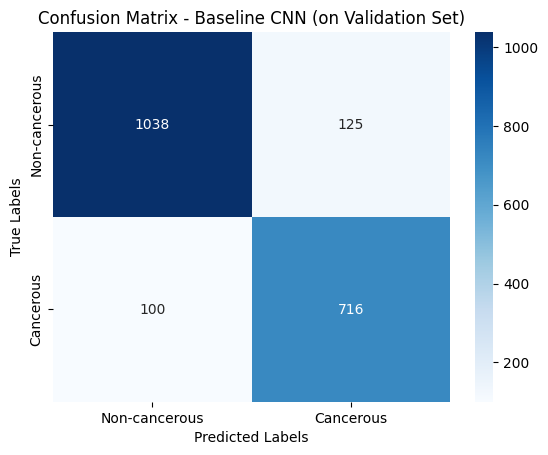

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


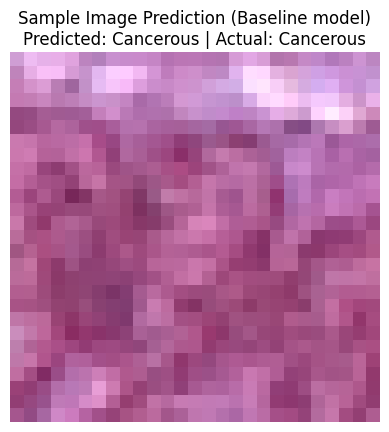

In [ ]:
#---------- Evaluating Baseline Model ----------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y1_val_probs = y1_cnn_baseline.predict(x_val) # baseline model predicting on the validation set

# Convert one-hot predictions and labels to class indices
y1_val_pred = np.argmax(y1_val_probs, axis=1)
y1_val_true = np.argmax(y1_val, axis=1)

# Classification report
class_labels = ['Non-cancerous', 'Cancerous']
print("Classification Report:\n")
print(classification_report(y1_val_true, y1_val_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y1_val_true, y1_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Baseline CNN (on Validation Set)')
plt.show()

# Sample image prediction on validation set
import random
def predict_random_image(x_data, y_data, model, class_labels):
    idx = random.randint(0, len(x_data) - 1) #random image

    img = x_data[idx] #retrieving random image
    actual_label = np.argmax(y_data[idx]) if y_data.ndim > 1 else y_data[idx] #retrieving actual label of the random image

    img_input = np.expand_dims(img, axis=0) #batch dimension

    #predicting image on baseline model
    prediction = model.predict(img_input)
    predicted_class = np.argmax(prediction)


    plt.figure(figsize=(3, 2))
    plt.imshow(img)
    plt.title(f"Sample Image Prediction (Baseline model)\nPredicted: {class_labels[predicted_class]} | Actual: {class_labels[actual_label]}")
    plt.axis('off')
    plt.show()

predict_random_image(x_val, y1_val, y1_cnn_baseline, class_labels)

**Baseline Model Evaluation**

Baseline model implemented a CNN architecture over MLP due to its ability to capture spatial patterns in images.

The baseline model's performance in predicting isCancerous displays a high f1-score of 0.88 and other metrics. Whilst this baseline model is performing relatively well, the above learning curves presented clear overfitting of the data, to which concludes that this model's performance is not the best representation for generalising to unseen data/new images. Making this model unfit.

Whilst the baseline's macro average treats all the classes equally in this imbalanced dataset, and presents a decently high average of 0.87, indicating that this baseline model performs pretty well on both classes, data augmentation and other possible parameter tuning is needed to produce a well generalising and accurate model.

#### Model Training (Parameter Tuning)

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#---------- Handling Class Imbalance by Data Augmentation on Minority Class of Y1 isCancerous ----------
minor_class = 1  #minority class is 1 = is cancerous as seen on the class imbalance identification in EDA
minor_ind = np.where(y1_train[:, minor_class] == 1)[0]
x_minor = x_train[minor_ind]
y1_minor = y1_train[minor_ind]

datagen = ImageDataGenerator( #light augmentation on the images to preserve key features
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

major_count = np.sum(y1_train[:, 0])
minor_count = len(x_minor)
n_samples = int(major_count - minor_count) #number of samples to generate matches the majority class (0 = is not cancerous)

augmented_images = []
augmented_labels = []
for x_batch, y1_batch in datagen.flow(x_minor, y1_minor, batch_size=32, shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y1_batch)
    if len(augmented_images) * 32 >= n_samples:
        break

# combining augmented samples with desired number of samples
x_aug = np.concatenate(augmented_images)[:n_samples]
y1_aug = np.concatenate(augmented_labels)[:n_samples]

# combining augmented samples with original training data
x_train_balanced = np.concatenate([x_train, x_aug])
y1_train_balanced = np.concatenate([y1_train, y1_aug])

print("Class distribution:", np.sum(y1_train_balanced, axis=0))

# printing sample augmented cancerous images (minority class (1 = is cancerous))
plt.figure(figsize=(6, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(x_aug[i])
    plt.axis('off')
    plt.title(f"Augmented #{i+1}")
plt.suptitle("Sample Augmented Images (isCancerous (1) Class)")
plt.show()

**Handling Class Imbalance**

To fix the slight *class imbalance on the Y1 isCancerous column as per shown in EDA*, data augmentation was implemented to the minority class previously identified in EDA as class 1 (is cancerous) with 4079 cases as compared with class 0 (is not cancerous) with 5817 cases. The images were augmentated with light changes to the rotation, horizontal and vertical shift, zooming, and flipped horizontally to avoid distorting the image features too much. As seen above, the sample augmented images show slight modifications to the images, barely noticeable to preserve key features. These augmented images were sampled back in to the original data to balance out both classes and the distribution of the classes are printed above.

In [ ]:
#---------- CNN Y1 (isCancerous) Param tuning model architecture ------------
y1_cnn_model = Sequential()
y1_cnn_model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3))) #adding l2 regularisation
y1_cnn_model.add(Activation('relu'))
y1_cnn_model.add(MaxPooling2D(pool_size =(2,2)))
y1_cnn_model.add(Dropout(0.25))

y1_cnn_model.add(Conv2D(64, (3, 3)))
y1_cnn_model.add(Activation('relu'))
y1_cnn_model.add(MaxPooling2D(pool_size =(2,2)))
y1_cnn_model.add(Dropout(0.25))

y1_cnn_model.add(Flatten())
y1_cnn_model.add(Dense(32))
y1_cnn_model.add(Activation('relu'))
y1_cnn_model.add(Dropout(0.5)) #adding dropout

y1_cnn_model.add(Dense(2))
y1_cnn_model.add(Activation('softmax'))

sgd = optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True) #using sgd optimiser over adam
#optimizer = Adam(learning_rate=0.0001)
y1_cnn_model.compile(loss='categorical_crossentropy',
                     optimizer=sgd,
                     metrics=['accuracy',
                              metrics.Precision(name='precision'),
                              metrics.Recall(name='recall'),
                              metrics.AUC(name='auc')]
                     )

In [ ]:
# Fitting y1 onto the model
history_model_y1 = y1_cnn_model.fit(x_train_balanced, y1_train_balanced,
                 epochs=100,
                 batch_size=32,
                 validation_data=(x_val, y1_val),
                  verbose=0)

In [ ]:
# Plotting loss and metric learning curves to check for overfitting
plot_learning_curves(history_model_y1, ['accuracy', 'precision', 'recall', 'auc'])

**Baseline + L2 Regularisation + Dropout + No. of Neurons + Learning Rate Model (Tuned Model) Generalisation**

After an iterative process of parameter tuning on the CNN baseline model for isCancerous, the improved model's learning curves above display less of a performance gap between the training and validation set. With a steady decrease in loss and no erratic spikes indicating stability within the validation set, the model shows no signs of overfitting or underfitting.

*The baseline parameter tuning included: L2 Regularisation, dropout, reduction of neurons, and learning rate.*

The implementation of dropout and regularisation within the model were the main contributors in improving generalisation of the model. A dropout rate of 0.25 in each convolutional layer, and a final strong rate 0.5 in the dense layer
allowed for the model to effectively drop random neurons in the convolutional layers, meaning that the model reduces the reliance on memorising the train data and thus can generalise more effectively. During model training, different values of dropout were tested and this lessened the performance gap between the train and validation set, however the validation set was erratic and still presented signs of overfitting.
After iterative training on L2 regularisation which balanced weights found that 0.01 regularisation along with dropout produced learning curves in all metrics that had little to no gap between the sets which is ideal. The instability within the validation set was improved by tuning the learning rate to 0.0001 from 0.001, this may explain that the model was skipping important data and so by further lessening the learning steps, the model is able to learn important information resulting in an almost ideal learning curves.

The number of neurons within the dense layer was also tuned down from 64 to 32 to reduce model complexity, because the model was previously overfitting.

The combination of the above parameters resulted in near idealistic learning curves that presented decent generalisation.

In [ ]:
#---------- Evaluating Param Tuned Model ----------
y1_val_probs = y1_cnn_model.predict(x_val) # model predicting on the validation set

# Convert one-hot predictions and labels to class indices
y1_val_pred = np.argmax(y1_val_probs, axis=1)
y1_val_true = np.argmax(y1_val, axis=1)

# Classification report
class_labels = ['Non-cancerous', 'Cancerous']
print("Classification Report:\n")
print(classification_report(y1_val_true, y1_val_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y1_val_true, y1_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Baseline CNN (on Validation Set)')
plt.show()

**Evaluation on the Tuned Model**

The **purpose of the validation set** in this model was to asses the performance during training whilst iteratively tuning the parameters, it also detected how well the model was fitting onto the data.

The process of hyperparameter tuning on the baseline model to improve performance was done iteratively. Whereby, each parameter was tuned on the model one at a time and evaluated to view it effects on the performance. After selecting the best performing rates for each parameter, a combination of parameters were specifically chosen to improve overfitting (which was the model's main issue) were included to the model and then evaluated and tuned again until an ideal generalisation and performance was achieved. The tuned parameters chosen were mentioned previously.

In order to **avoid patient-based data leakage**, the model is evaluated on a seperate validation set that simulates unseen data. Preventing the model to memorise specific patients cell patterns as it will fail to detect cancerous cases with unseen patients in the real world due to leakage. Another possible solution apart from splitting the data is augmenting the image data so that the model can learn images and still perform well on unseen data as the augmented images differ.

#### Evaluation

**Final isCancerous Model Evaluation**

Due to the slight imbalance within class "isCancerous", the accuracy metric itself *may provide misleading information* as it ignores how well each class is predicted. The addition of precision, recall, AUC and F1 score ensured that the model can be judged overall and identifies how many cancerous and non-cancerous cases are correctly predicted per class.

The final model chosen to predict Y1 "isCancerous" is the tuned model, the tuning of parameters resulted in a high balanced f1-score across classes (cancerous and non-cancerous) of 0.86 and 0.89. Whilst being well generalised to unseen data, the model also retrieves high accuracy, precision, recall, f1-scores of above 0.81. This model produces an improvement particularly in the recall of cancerous cases, with a high recall score of 0.91, this is crucial as there is higher need to detect cancerous cases of patients.

This improvement in performance is due to the reduction of model complexity in the baseline by lessening the neurons and implementing regularisation and dropout to the model. Resulting in improved generalisation and therefore accurate/reliable performance.

** **
**Comparative Analysis**

**Final isCancerous Model vs. Baseline Model**

The final model displays a steadier increase in both train and validation sets in all metrics, with little spikes in the validation set as compared to the baseline model's learning curve with erratic instability and a performance gap. Although the baseline performance displays an overall high macro average of 0.88, it only indicates high performance specific to the train data. When evaluated on unseen data, this model will be deemed inaccurate and unreliable due to model overfit.
Whilst the tuned model has a slightly lower performance in some metrics compared to the baseline as seen in the table below, this model can generalise well to unseen data whilst also accurately performing well in predicting classes. *This comparison between baseline and the final isCancerous model is **valid** due to identical metrics, a combination of parameters contributed to the change in results, however lessening the learning rate was a main contributor to the improvement.*

<div align="center">

| Class          | Metric     | Baseline Model | Tuned Model |
|----------------|------------|----------------|-------------|
| Non-cancerous  | Precision  | 0.91           | 0.93        |
|                | Recall     | 0.89           | 0.85        |
|                | F1 Score   | 0.90           | 0.89        |
| Cancerous      | Precision  | 0.85           | 0.81        |
|                | Recall     | 0.87           | 0.91        |
|                | F1 Score   | 0.86           | 0.86        |
| **Overall**    | Accuracy   | 0.88           | 0.88        |
|                | Macro Avg  | 0.88           | 0.87        |
| Generalisation |            | Overfitting    | Fitting well   

</div>


**Final isCancerous Model vs Academic Literature**

The academic literature by Sirinukunwattana et al., proposes detection and classification techniques of nuclei. The research paper classifies each detected nucleus into one of the 4 classes of Epithelial, Inflammatory, Fibroblast, and Miscellaneous using 4 different models. Whereby the epithelial nucleus class is the only cancerous nuclei within this study.
Since my final isCancerous model is a binary classification detecting if the cell is cancerous or not, an average of all the literature's model's F1-score for the 3 non-cancerous nucleus (inflammatory, fibroblast, and miscellaneous) will be compared against my models "non-cancerous" F1-score. The literature's f1-score for classifying the epithelial nuclei will be compared against my model's "cancerous" f1-score. Figure 7 and table III in the literature is used to compare results with my final model.

<div align="center">
Classifying Cancerous

|                     | Model                   | F1-Score       |
|---------------------|-------------------------|----------------|
| My Model            | Final isCancerous Model | 0.86           |
| Academic Literature | Softmax CNN + SSPP      | 0.85           |
|                     | Softmax CNN + NEP       | 0.88           |
|                     | Superpixel descriptor   | 0.80           |
|                     | CRImage                 | 0.49           |
</div>

It can be seen by the table above that the literature's softmax CNN + NEP model performs the best, leading by 0.02 over my final isCancerous model. The literature's model performs slightly better in classifying cancerous cells in the data, however comparison is limited due to comparison only on f1-score for all models.

<div align="center">
Classifying Non-cancerous

|                     | Model                   | F1-Score       |
|---------------------|-------------------------|----------------|
| My Model            | Final isCancerous Model | 0.89           |
| Academic Literature | Softmax CNN + SSPP      | 0.63           |
|                     | Softmax CNN + NEP       | 0.68           |
|                     | Superpixel descriptor   | 0.56           |
|                     | CRImage                 | 0.40           |
</div>

The literature's model's f1-scores for all models detecting non-cancerous cells perform much poorly than their classification in cancerous cells. My final isCancerous model performs the best with an f1-score of 0.89, followed by the literature's softmax CNN + NEP model with 0.68.

My final isCancerous model performed similarly to the literature's softmax CNN + NEP model in classifying cancerous cells, however my model greatly exceeded the performance amongst the literature's models for classifying non-cancerous cells based on f1-scores. This **may be misleading or unfair** as the comparison is limited in metrics, whilst the literature also uses precision, recall and auc as metrics, its performance and results are determined by the f1-score of their models, thus limited to only f1-score.

### Task 2: Classifying Cell Type
**Author: Joelle**

#### Model Building (Baseline)

In [ ]:
# Extracted from course content
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Build the model
y2_model = Sequential()

# Block 1
y2_model.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
y2_model.add(Activation('relu'))
y2_model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
y2_model.add(Conv2D(64, (3, 3)))
y2_model.add(Activation('relu'))
y2_model.add(MaxPooling2D(pool_size=(2, 2)))

# Classification head
y2_model.add(Flatten())              # Flatten the output for the dense layer
y2_model.add(Dense(64))              # Dense layer with 64 units
y2_model.add(Activation('relu'))
y2_model.add(Dense(4))               # 4 output classes for cellTypeName
y2_model.add(Activation('softmax'))  # Softmax for multi-class classification

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Instantiate Adam optimizer
y2_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,  # Use the instantiated optimizer here
              metrics=['accuracy'])

# Fit the model to the data
y2_model.fit(x_train, y2_train, epochs=10,  # Number of epochs to train
          batch_size=32,  # Size of the batches for each training step
          validation_data=(x_val, y2_val),  # Validation data (optional, but recommended)
          verbose=1  # Show progress bar during training (0 = silent, 1 = progress bar)
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5237 - loss: 1.1423 - val_accuracy: 0.6761 - val_loss: 0.8057
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6840 - loss: 0.8164 - val_accuracy: 0.6892 - val_loss: 0.7741
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7060 - loss: 0.7438 - val_accuracy: 0.7135 - val_loss: 0.7352
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7337 - loss: 0.6987 - val_accuracy: 0.6918 - val_loss: 0.7602
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7262 - loss: 0.7045 - val_accuracy: 0.7302 - val_loss: 0.6881
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7414 - loss: 0.6670 - val_accuracy: 0.7302 - val_loss: 0.6856
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7542 - loss: 0.6404 - val_accuracy: 0.7302 - val_loss: 0.6956
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7474 - loss: 0.6632 - val_accuracy: 0

In [ ]:
loss, accuracy = y2_model.evaluate(x_val, y2_val, verbose=1)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

test_loss, test_accuracy = y2_model.evaluate(x_test, y2_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7177 - loss: 0.7141
Validation Loss: 0.6734
Validation Accuracy: 0.7413
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7345 - loss: 0.6999
Test Accuracy: 0.7439


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = y2_model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y2_val, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[226  43  86  33]
 [ 23 369  58  53]
 [ 15  34 759   8]
 [ 41  75  43 113]]
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       388
           1       0.71      0.73      0.72       503
           2       0.80      0.93      0.86       816
           3       0.55      0.42      0.47       272

    accuracy                           0.74      1979
   macro avg       0.70      0.67      0.68      1979
weighted avg       0.73      0.74      0.73      1979



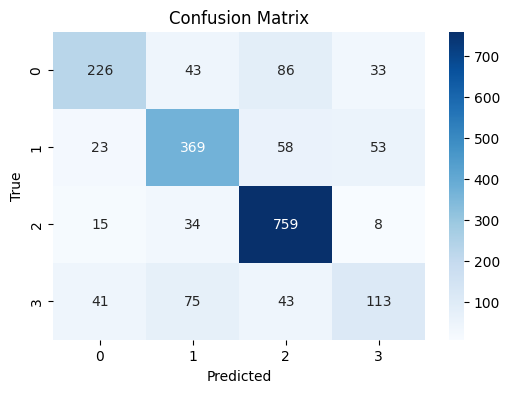

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# For one-hot encoded true and predicted probs
auc = roc_auc_score(y2_val, y_pred, multi_class='ovr')
print(f"Macro AUC: {auc:.4f}")


Macro AUC: 0.9079


In [ ]:
# Train the model and capture history
history = y2_model.fit(
    x_train, y2_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y2_val),
    verbose=1
)


Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7809 - loss: 0.5735 - val_accuracy: 0.7463 - val_loss: 0.6680
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7867 - loss: 0.5702 - val_accuracy: 0.7383 - val_loss: 0.7071
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8043 - loss: 0.5322 - val_accuracy: 0.7408 - val_loss: 0.6764
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7995 - loss: 0.5314 - val_accuracy: 0.7463 - val_loss: 0.6679
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8087 - loss: 0.5051 - val_accuracy: 0.7317 - val_loss: 0.6791
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8041 - loss: 0.4967 - val_accuracy: 0.7372 - val_loss: 0.6815
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8364 - loss: 0.4432 - val_accuracy: 0.7549 - val_loss: 0.6701
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8388 - loss: 0.4366 - val_accuracy: 0.

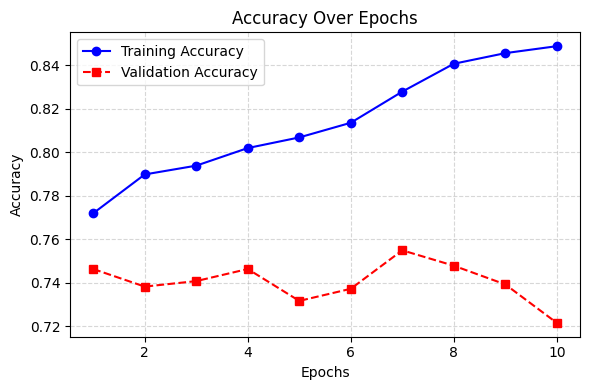

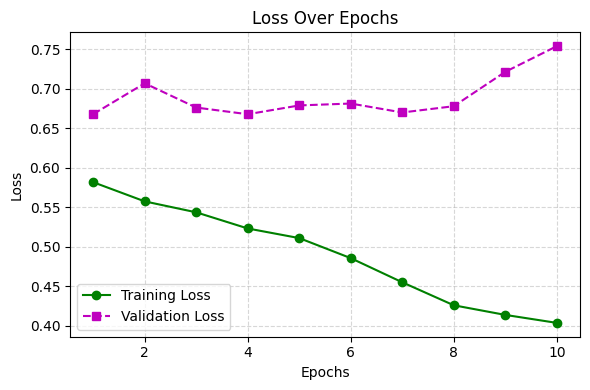

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, metric_name='accuracy'):
    """
    Plots training & validation accuracy and loss from model history.
    """
    epochs = range(1, len(history.history[metric_name]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history.history[metric_name], 'b-o', label='Training Accuracy')
    plt.plot(epochs, history.history['val_' + metric_name], 'r--s', label='Validation Accuracy')
    plt.title(f'{metric_name.title()} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.title())
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Loss
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history.history['loss'], 'g-o', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'm--s', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curves(history, metric_name='accuracy')


In [ ]:
y2_model.save('baseline_y2_model.keras')


#### Model Training (Parameter Tuning)

#### Evaluation

## Ultimate Judgement

## Conclusion